In [33]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import numpy as np
from scipy import io, stats, optimize
import matplotlib.pyplot as plt
from seaborn import despine
from statsmodels.tsa.stattools import acf

# nonstandard imports
from fooof import FOOOF
from neurodsp import spectral

sys.path.append('../')
import echo_utils

font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 14}
plt.rc('font', **font)

import warnings
warnings.filterwarnings('ignore')

fig_path = '../figures/sim/%s.pdf'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
datafolder = '/Users/rdgao/Documents/data/NeuroTycho/Propofol/20120802PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/Session1/'
chan = 20 #45 #20 #127
data_exmp = io.loadmat(datafolder+'ECoG_ch%i.mat'%chan, squeeze_me=True)['ECoGData_ch%i'%chan]
cond = io.loadmat(datafolder+'Condition.mat', squeeze_me=True)
data = data_exmp[cond['ConditionIndex'][2]:cond['ConditionIndex'][3]]
fs = 1000


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

19.39452438346076 0.008206179225906633 3.8147519723025356


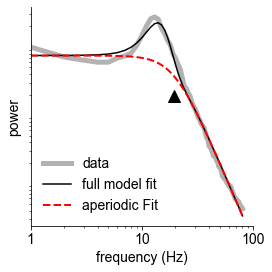

In [49]:
fit_range=[1,80]
plt_inds = np.arange(fit_range[0],fit_range[1]+1)
faxis, psd = spectral.compute_spectrum(data,fs,avg_type='median')

# fit fooof without knee
fo0 = FOOOF(max_n_peaks=2, aperiodic_mode='fixed')
fo0.fit(faxis, psd, fit_range)

# fit fooof with knee
fok = FOOOF(max_n_peaks=2, aperiodic_mode='knee')
fok.fit(faxis, psd, fit_range)
offset, knee, exp = fok.get_params('aperiodic_params')
kfreq, tau = echo_utils.convert_knee_val(knee,exp)
print(kfreq, tau, exp)

plt.figure(figsize=(4,4))
plt.loglog(faxis[plt_inds], psd[plt_inds], 'k', lw=5, alpha=0.3)
#plt.loglog(faxis[plt_inds], 10**fo0.fooofed_spectrum_)
plt.loglog(faxis[plt_inds], 10**fok.fooofed_spectrum_, 'k-')



plt.loglog(faxis[plt_inds], 10**offset/(knee+faxis**exp)[plt_inds], '--r', lw=2)
plt.xlim([1,100])
plt.xlabel('frequency (Hz)');plt.ylabel('power');
plt.xticks([1, 10, 100], ['1','10', '100']);plt.yticks([]);
plt.legend(['data', 'full model fit', 'aperiodic Fit'], frameon=False)
#plt.plot(kfreq, plt.ylim()[1]*0.9, '^k', ms=12)

plt.plot(kfreq, 10**offset/(knee+faxis**exp)[np.where(faxis==np.round(kfreq))[0]]*0.5, '^k', ms=12)

despine(); plt.tight_layout()
plt.savefig(fig_path%'fooof_schematic')

In [27]:
# compute autocorrelation function
max_lag=250
t_ac = np.arange(0,max_lag+1)/fs
ac = acf(data, nlags=max_lag, fft=True)

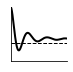

In [40]:
# plot a tiny autocorrelation function for inset
plt.figure(figsize=(1,1))
plt.plot(t_ac*1000, ac, 'k', lw=2)
plt.axhline(0, lw=1, ls='--', color='k')
plt.xlim([0,250])
plt.xticks([]); plt.yticks([]); plt.ylim([-0.5,1])
despine()
plt.savefig(fig_path%'acf_schematic')

# Fitting Multi-Timescale PSD and ACF

short tau = 16.050 ms
long tau = 2035.109 ms


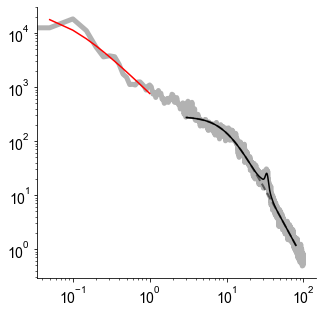

In [107]:
winlen = 20
faxis, psd = spectral.compute_spectrum(data,fs,avg_type='median', nperseg=int(fs*winlen), noverlap=int(fs*winlen*3/4))

plt.figure(figsize=(5,5))
plt.loglog(faxis[:winlen*100], psd[:winlen*100], 'k', lw=5, alpha=0.3)


# fit fooof with high knee
fit_range=[3,80]
plt_inds = np.arange(fit_range[0]*winlen, fit_range[1]*winlen+1).astype(int)
fok = FOOOF(max_n_peaks=2, aperiodic_mode='knee')
fok.fit(faxis, psd, fit_range)
offset, knee, exp = fok.get_params('aperiodic_params')
kfreq, tau = echo_utils.convert_knee_val(knee,exp)
plt.loglog(faxis[plt_inds], 10**fok.fooofed_spectrum_, 'k-')
plt.loglog(faxis[plt_inds], 10**offset/(knee+faxis**exp)[plt_inds], '--k', lw=2, alpha=0.5)
print('short tau = %.3f ms'%(tau*1000))

# fit fooof with low knee
fit_range=[0.05,1]
plt_inds = np.arange(fit_range[0]*winlen, fit_range[1]*winlen+1).astype(int)
fok = FOOOF(max_n_peaks=2, aperiodic_mode='knee')
fok.fit(faxis, psd, fit_range)
offset, knee, exp = fok.get_params('aperiodic_params')
kfreq, tau = echo_utils.convert_knee_val(knee,exp)
plt.loglog(faxis[plt_inds], 10**fok.fooofed_spectrum_, 'r-')

print('long tau = %.3f ms'%(tau*1000))
despine()

single tau = 188.594 ms
short tau = 33.017 ms, long tau = 1085.786 ms


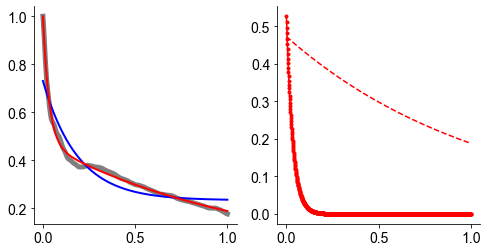

In [115]:
# compute autocorrelation function
max_lag=1000
t_ac = np.arange(0,max_lag+1)/fs
ac = acf(data, nlags=max_lag, fft=True)

p_bounds =([0, 0, 0], [10, np.inf, np.inf])
p_le = optimize.curve_fit(echo_utils.exp_lt_func, t_ac, ac, bounds = p_bounds)[0]
print('single tau = %.3f ms'%(p_le[0]*1000))
p_bounds =([0, 0, 0, 0, 0], [10, 10, np.inf, np.inf, np.inf])
p_2e = optimize.curve_fit(echo_utils.exp2_func, t_ac, ac, bounds = p_bounds)[0]


plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(t_ac, ac, 'k', lw=5, alpha=.5)
plt.plot(t_ac, echo_utils.exp_lt_func(t_ac, p_le[0],p_le[1],p_le[2]), 'b', lw=2)
plt.plot(t_ac, echo_utils.exp2_func(t_ac, p_2e[0],p_2e[1],p_2e[2], p_2e[3],p_2e[4]), 'r', lw=2)
despine()

plt.subplot(1,2,2)
plt.plot(t_ac, echo_utils.exp_lt_func(t_ac, p_2e[0],p_2e[2],0), 'r--')
plt.plot(t_ac, echo_utils.exp_lt_func(t_ac, p_2e[1],p_2e[3],0), 'r.-')
despine()
print('short tau = %.3f ms, long tau = %.3f ms'%(min(p_2e[0],p_2e[1])*1000, max(p_2e[0],p_2e[1])*1000))

### Testing Different ACF Implementations

In [38]:
def autocorr1(data, max_lag=1000):
    """ Calculate the signal autocorrelation (lagged correlation)

    Parameters
    ----------
    data : array 1D
        Time series to compute autocorrelation over.
    max_lag : int (default=1000)
        Maximum delay to compute AC, in samples of signal.

    Returns
    -------
    t_acf : array, 1D
        Time points (in samples) at which correlation was computed.
    acf : array, 1D
        Time lagged (auto)correlation.

    """
    ###
    # have FT implementation
    ###
    t_acf = np.arange(0, max_lag)
    acf = np.zeros(max_lag)
    acf[0] = np.sum((data - np.mean(data))**2)
    for lag in range(1,max_lag):
        x, y = data[:-lag], data[lag:]
        acf[lag] = ((x-x.mean())*(y-y.mean())).sum()
    return t_acf, acf/acf[0]

def autocorr2(x, max_lag):
    acf = np.zeros(max_lag)
    acf[0] = 1
    for lag in range(1,max_lag):
        acf[lag] = np.corrcoef(data[:-lag], data[lag:])[0,1]    
    return acf